# AQUAthon, breakout 2: Navigating the depths

### Accessing high resolution data in FDB, streaming, fixes and catalogue entries

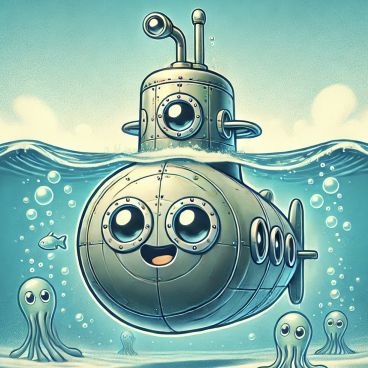

In this session we will explore some more advanced aspects of AQUA.

The best way to use this notebook is to assume that you have effectively followed [the instructions](https://siili.rahtiapp.fi/DUnxpPLkS-CFG0viTDRrRQ?view#Jupyter-notebooks-with-AQUA) from the  plenary session and requested an interactive job. Please do not try to run this notebook directly on the login node of Lumi or Levante, as most likely there will not be enough memory and cores available.

We will assume that you have already the `climatedt-phase1`, `nextgems4` and `obs` catalogues installed (`aqua add <catalogue>`). 

**A summary of topics covered:**

* [Direct FDB access, dask and parallelization](#direct-fdb-access-dask-and-parallelization)
* [Streaming access](#streaming-access)
* [Fixing variables](#the-fixer)
* [Grid definitions](#grid-definitions)

## Direct FDB access, dask and parallelization

AQUA can provide direct access to FDB sources (HPC FDB or Data Bridge) returning a fully dask-enabled xarray. This means that we have the following benefits: parallelization, efficient memory usage and lazy computation. 
Let's explore how to profit from these features.

### Direct FDB data access

We start by loading some data from a known FDB source, at the highest available resolution (HEALPix hpz9 in this case)

In [5]:
from aqua import Reader

# Adapt for you machine:
# on levante
reader = Reader(catalog="nextgems4", model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d")
# on lumi
# reader = Reader(catalog="climatedt-phase1", model="IFS-FESOM", exp="story-2017-historical", source="hourly-hpz9-atm2d")

For efficiency we will retrieve only one variable, but you could omit the `var` keyword:

In [6]:
data = reader.retrieve(var="2t")

The result is as usual an xarray **Dataset**

In [7]:
data

<xarray.Dataset> Size: 2TB
Dimensions:  (ncells: 3145728, time: 87648)
Coordinates:
    lon      (ncells) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    lat      (ncells) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
  * time     (time) datetime64[ns] 701kB 1990-01-01 ... 1999-12-31T23:00:00
Dimensions without coordinates: ncells
Data variables:
    2t       (time, ncells) float64 2TB dask.array<chunksize=(24, 3145728), meta=np.ndarray>
Attributes:
    history:  \n2024-09-12 14:33:47 AQUA💧: Retrieved from IFS-FESOM_historica...

You can already notice that "2t" is a `dask.array`. If we look more carefully we can see the structure of the data["2t"] DataArray

In [8]:
t2m = data["2t"]
t2m

<xarray.DataArray '2t' (time: 87648, ncells: 3145728)> Size: 2TB
dask.array<concatenate, shape=(87648, 3145728), dtype=float64, chunksize=(24, 3145728), chunktype=numpy.ndarray>
Coordinates:
    lon      (ncells) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    lat      (ncells) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
  * time     (time) datetime64[ns] 701kB 1990-01-01 ... 1999-12-31T23:00:00
Dimensions without coordinates: ncells
Attributes: (12/20)
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   air_temperature
    GRIB_paramId:                    167
    GRIB_shortName:                  2t
    GRIB_units:                      K
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   healpix
    GRIB_gridDefinitionDescription:  150
    gridtype:                        healpix
    history:                         2024-09-12 14:33:47 Dataset retrieved by...

Notice the description "Dask graph: 3652 chunks in 18261 graph layers" .... this is a **lazy (delayed) dask array**.
Also notice that the data are **chunked**, split into smaller units. In this case chunking is daily, so a single chunk is 24 spatial frames of hourly data, but different chunking can be implemented (for example vertical chunking for 3D data).
The size of the chunks has been chosen by default in the catalogue so that each dask worker had enough to do and work on, but this can be finetuned, passing the kwarg `chunks` to the `Reader` class when specifying the data source. Please check the documentation on how to use in detail this option.

This chunking allows dask to implement efficient usage of the machine's resources. Dask also implements *lazy data access*: operations on the xarray are almost instantaneous, since dask simply stores the *intention* to do given operations. Only when finally a calculation is actually required (e.g. to prepare a plot, save data, provide a number), only the calculations which are strictly needed are performed, with optimal use of resources.

If (for example) we select a specific range of dates, only those data will be effectively retrieved from the fdb when needed for the calculation, an example of lazy access.


In [9]:
t2m_selected = t2m.sel(time=slice("1991-01-01", "1991-06-30"))  # change dates to 2017 on Lumi
t2m_selected

<xarray.DataArray '2t' (time: 4344, ncells: 3145728)> Size: 109GB
dask.array<getitem, shape=(4344, 3145728), dtype=float64, chunksize=(24, 3145728), chunktype=numpy.ndarray>
Coordinates:
    lon      (ncells) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    lat      (ncells) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
  * time     (time) datetime64[ns] 35kB 1991-01-01 ... 1991-06-30T23:00:00
Dimensions without coordinates: ncells
Attributes: (12/20)
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   air_temperature
    GRIB_paramId:                    167
    GRIB_shortName:                  2t
    GRIB_units:                      K
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   healpix
    GRIB_gridDefinitionDescription:  150
    gridtype:                        healpix
    history:                         2024-09-12 14:33:47 Dataset retrieved by...

Let's plan an operation requiring calculation on some data. Notice that only when needed the data will be effectively retrieved from the FDB. We limit ourselves to the first month of data.

In [10]:
t2m_fldmean = t2m_selected.isel(time=slice(0,24*31)).aqua.fldmean()
t2m_fldmean

<xarray.DataArray '2t' (time: 744)> Size: 6kB
dask.array<truediv, shape=(744,), dtype=float64, chunksize=(24,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 6kB 1991-01-01 ... 1991-01-31T23:00:00
Attributes: (12/20)
    long_name:                       2 metre temperature
    units:                           K
    standard_name:                   air_temperature
    GRIB_paramId:                    167
    GRIB_shortName:                  2t
    GRIB_units:                      K
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_stepType:                   instant
    GRIB_gridType:                   healpix
    GRIB_gridDefinitionDescription:  150
    gridtype:                        healpix
    history:                         2024-09-12 14:33:47 Dataset retrieved by...

computation and retrieval from the FDB is performed only when you plot


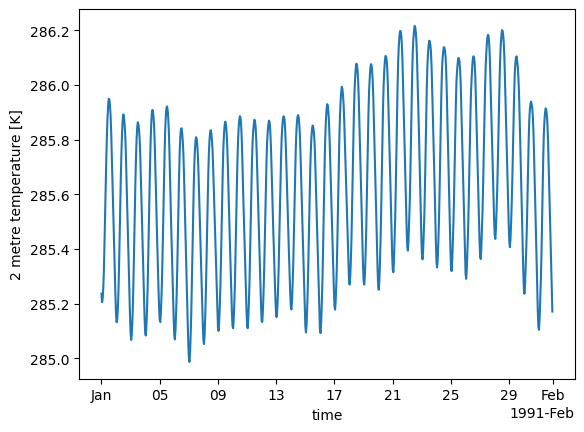

In [11]:
t2m_fldmean.plot()

So it took about 1m6s to retrieve, compute and plot 31 days of hourly data at hpz9 resolution.
This time was spent both in retrieving the data and in computing the field average. It will scale linearly (approximately) with the length of the chosen time window. Dask performs this computation in parallel using as many processors of the machine as it can and automatically managing memory usage.


### Parallelization with dask.distributed

We can (sometimes) accelerate things and get more control over resource usage by instantiating a local parallel cluster (this needs to be done only once at the beginning of your code). How effective this is will depend on the computational load left for each core, on memory usage by each core and on your chunking choices.

In [59]:
from dask.distributed import LocalCluster, Client

cluster = LocalCluster(n_workers=32, threads_per_worker=1,  memory_limit='6.5GB')

/home/b/b382075/mambaforge/envs/aqua/lib/python3.12/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40215 instead
  warnings.warn(


and we instantiate a client

In [60]:
client = Client(cluster)

Now we try again, but let's be more ambitious, we plan to plot 2 months of data:

/home/b/b382075/mambaforge/envs/aqua/lib/python3.12/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 27.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/b/b382075/mambaforge/envs/aqua/lib/python3.12/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 27.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/b/b382075/mambaforge/envs/aqua/lib/python3.12/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 27.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
/home/b/b382075/mambaforge/envs/aqua/lib/python3.12/site-packages/distributed/client.py:3169: UserWarning: Sending large graph of size 27.00 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.wa

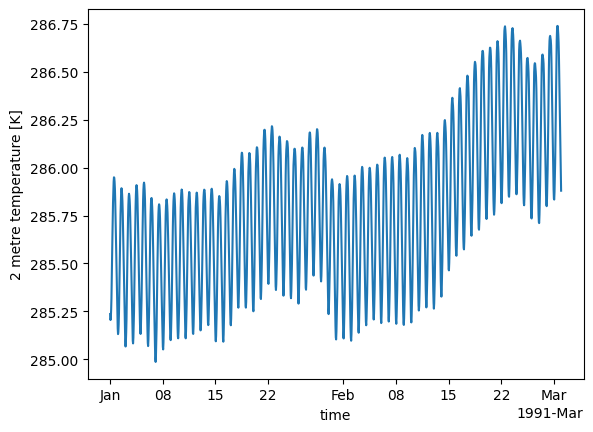

In [40]:
t2m_fldmean = t2m_selected.isel(time=slice(0,24*60)).aqua.fldmean()
t2m_fldmean.plot()

Well, that's good! In about half a minute we can plot 60 days this time.

In this case the speedup is intermediate (a factor 4 using 16 cores) but depending on the actual diagnostic being run even more dramatic speedups can be obtained. The `aqua-analysis` script described in the other breakout session implements dask parallelization using between 4 and 16 cores for each diagnostic on the same node.

As you can see there is a lot of optimization which can be achieved by finding the right balance between number of workers and size of chunks. The default chunk size specified in the catalogue can be overridden by specifying the `chunks` keyword to the `Reader`, e.g. `chunks="6H"`. This could also a dictionary for more complex cases where chunking is done in two coordinates (e.g. time and vertical: `chunks={"time": "6H", "vertical": 5}` default is time.

Let's not forget to close our cluster and client (always remember to do this)

In [57]:
client.shutdown()
cluster.close()

## Streaming access

Streaming is an alternative to pure dask/xarray access. You do not need to use streaming to access the data (in most cases directly working with xarray/dask should be more efficient) but in some cases this approach may be convenient.

We can ask the reader to provide the data in smaller bits by specifying the `streaming` kwyword, together with a desired temporal `aggregation` (this defaults to a single timestep):

### Reader-based streaming

This is 'soft' implementation of streaming where the reader already splits the data in chunks for you. The same effect could actually obtained manually by using the methods `.sel()` or `.isel()` on the data xarray.

In [37]:
from aqua import Reader

# Adapt for you machine:
# on levante
reader = Reader(catalog="nextgems4", model="IFS-FESOM", exp="historical-1990", 
                source="hourly-hpz9-atm2d", streaming="true", aggregation="MS")
# on lumi
# reader = Reader(catalog="climatedt-phase1", model="IFS-FESOM", exp="story-2017-historical",
#                 source="hourly-hpz9-atm2d", streaming="true", aggregation="MS")

In [38]:
data = reader.retrieve(var="2t")
data

<xarray.Dataset> Size: 19GB
Dimensions:  (ncells: 3145728, time: 744)
Coordinates:
    lon      (ncells) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    lat      (ncells) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
  * time     (time) datetime64[ns] 6kB 1990-01-01 ... 1990-01-31T23:00:00
Dimensions without coordinates: ncells
Data variables:
    2t       (time, ncells) float64 19GB dask.array<chunksize=(24, 3145728), meta=np.ndarray>
Attributes:
    history:  \n2024-09-08 13:26:28 AQUA💧: Retrieved from IFS-FESOM_historica...

Please notice that data are still an xarray enabled with dask.
Next time you call the reader you will get the next chunk: 

In [39]:
data = reader.retrieve(var="2t")
data

<xarray.Dataset> Size: 17GB
Dimensions:  (ncells: 3145728, time: 672)
Coordinates:
    lon      (ncells) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    lat      (ncells) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
  * time     (time) datetime64[ns] 5kB 1990-02-01 ... 1990-02-28T23:00:00
Dimensions without coordinates: ncells
Data variables:
    2t       (time, ncells) float64 17GB dask.array<chunksize=(24, 3145728), meta=np.ndarray>
Attributes:
    history:  \n2024-09-08 13:26:40 AQUA💧: Retrieved from IFS-FESOM_historica...

### Iterator access

As an alternative you can ask the reader to return an *iterator/generator*:

In [56]:
# on levante
reader = Reader(catalog="nextgems4", model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d", 
                streaming="true", aggregation="D", stream_generator=True)
# on lumi
# reader = Reader(catalog="climatedt-phase1", model="IFS-FESOM", exp="ssp370", source="hourly-hpz10-atm2d",
#                 streaming="true", aggregation="D", stream_generator=True)

*Notice that we changed aggregation to daily, you will see below why*

In [57]:
dataiter = reader.retrieve(var="2t")
dataiter

<generator object FixerMixin._fixergen at 0x7ff9bca75b40>

In [58]:
data = next(dataiter)
data

<xarray.Dataset> Size: 856MB
Dimensions:     (ncells: 3145728, cell_corners: 4, time: 24)
Coordinates:
    lon         (ncells) float64 25MB 45.0 45.09 44.91 ... 315.1 314.9 315.0
    lat         (ncells) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
    lon_bounds  (ncells, cell_corners) float64 101MB 45.0 44.91 ... 315.0 315.1
    lat_bounds  (ncells, cell_corners) float64 101MB 0.1492 0.0746 ... -0.0746
  * time        (time) datetime64[ns] 192B 1990-01-01 ... 1990-01-01T23:00:00
Dimensions without coordinates: ncells, cell_corners
Data variables:
    2t          (time, ncells) float64 604MB 299.2 299.2 299.2 ... 300.9 300.9
Attributes:
    history:  \n2024-09-08 13:36:20 AQUA💧: Retrieved from IFS-FESOM_historica...

<font color="red">**An important difference: by using iterator access the returned data are now a simple xarray without dask. All the data are actually loaded in memory!** You will have to pay attention that they fit and you lose other dask advantages such as lazy computation and parallelization.

Since `dataiter` is an iterator you could do something like this:

In [ ]:
for data in dataiter:
  # ... do something with data

## The fixer

AQUA can adapt external data to a desired format in terms of variable names, units etc. making it possible for example to transform external observations (e.g. ERA5) into the GSV format on the fly.

As an example, when we load data from CERES or ERA5

In [67]:
reader = Reader(catalog="obs", model="CERES", exp="ebaf-toa41", source="monthly")
obs = reader.retrieve()
obs

<xarray.Dataset> Size: 893MB
Dimensions:                      (lon: 360, lat: 180, time: 265)
Coordinates:
  * lon                          (lon) float32 1kB 0.5 1.5 2.5 ... 358.5 359.5
  * lat                          (lat) float32 720B -89.5 -88.5 ... 88.5 89.5
  * time                         (time) datetime64[ns] 2kB 2000-03-15 ... 202...
Data variables: (12/13)
    toa_sw_all_mon               (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_lw_all_mon               (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_net_all_mon              (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_sw_clr_c_mon             (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_lw_clr_c_mon             (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    toa_net_clr_c_mon            (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    ...                           ...
    cldarea_total_daynight_mon   (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    cldpress_total_daynight_mon  (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    cldtemp_total_daynight_mon   (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    cldtau_total_day_mon         (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    mtnlwrf                      (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
    mtnswrf                      (time, lat, lon) float32 69MB dask.array<chunksize=(265, 180, 360), meta=np.ndarray>
Attributes:
    title:        CERES EBAF (Energy Balanced and Filled) TOA Fluxes. Monthly...
    institution:  NASA/LaRC (Langley Research Center) Hampton, Va
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date May 28, 2019
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF-TOA_L3B004.1
    history:      \n2024-09-08 13:52:12 AQUA💧: Retrieved from CERES_ebaf-toa4...

we get already variables in the same units and variable names in the GSV of the DestinE standard portfolio, such as `mtnlwrf` (TOA Longwave Flux - All-Sky)

How does this actually work?

Let's look at an intake catalog source of AQUA in detail

```yaml
plugins:
  source:
    - module: intake_xarray

sources:
  monthly:
    description: CERES EBAF TOA Ed4.1 from 2000 to 2022
    driver: netcdf
    metadata:
      source_grid_name: lon-lat
      fixer_name: ceres-ebaf-destine-v1
    args:
      urlpath: '{{DATA_PATH}}/CERES/EBAF_v4.1/CERES_EBAF-TOA_Ed4.1_Subset_200003-202203.nc'
      chunks: {}
      xarray_kwargs:
        decode_times: True
```

Notice the line with `fixer_name`. This is a special 'fixer' which postprocesses the variables and their metadata to provide the desired output format.

In turn in your `.aqua` folder you will find `.aqua/fixes` containing various 'fixer' files. As an example `.aqua/fixes/OBS-climatedt-v1.yaml` contains:

```yaml
fixer_name:
    ceres-ebaf-destine-v1:
        data_model: False
        vars:
            mtnlwrf:
                derived: 0.-toa_lw_all_mon
                grib: true
                attributes:
                    valid_min: -500
                    valid_max: 0
                    positive: down
            mtnswrf:
                derived: solar_mon-toa_sw_all_mon
                grib: true
                attributes:
                    valid_min: 0
                    valid_max: 1400
                    positive: down
            msnlwrf:
                derived: 0.-sfc_net_lw_all_mon
                grib: true
            msnswrf:
                derived: sfc_net_sw_all_mon
                grib: true
```

The detailed syntax is described in the [documentation](https://aqua-web-climatedt.2.rahtiapp.fi/documentation/core_components.html#fixer-functionalities). In this case actual calculation is done with the variables (sign change and differences). In other cases we may simply wish to change units and grib code/definition. For example this entry from the ERA5 fixer simply applies all desired properties (units etc) of a known grib code to the source variable, converting units as needed (in this case the source units were ambigous, so we specify the - usually not needed):

```yaml
mer:
    grib: true
    source: E
    src_units: m/day
```

## Catalogue entries

Let's check more in detail how a catalogue entry is actually structured. To this end we will switch to the [github repository for our catalogues](https://github.com/DestinE-Climate-DT/Climate-DT-catalog/blob/main/catalogs/climatedt-phase1/catalog/IFS-FESOM/ssp370.yaml).

## Grids




For most sources AQUA needs grid definition files to provide essential information such as grid cell areas (for area weighting) and to be used to generate the weights for interpolation.

When we instantiate the reader for a given source

In [2]:
from aqua import Reader
# on levante
reader = Reader(catalog="nextgems4", model="IFS-FESOM", exp="historical-1990", source="hourly-hpz9-atm2d", 
                streaming="true", aggregation="D", stream_generator=True)
# on lumi
# reader = Reader(catalog="climatedt-phase1", model="IFS-FESOM", exp="ssp370", source="hourly-hpz10-atm2d",
#                 streaming="true", aggregation="D", stream_generator=True)

It provides also a `grid_area` attribute with the cell areas, to be used e.g. for weighting (the method `fldmean()` uses this automatically)

In [11]:
reader.grid_area

<xarray.DataArray 'cell_area' (ncells: 3145728)> Size: 25MB
dask.array<open_dataset-cell_area, shape=(3145728,), dtype=float64, chunksize=(3145728,), chunktype=numpy.ndarray>
Coordinates:
    lon      (ncells) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
    lat      (ncells) float64 25MB dask.array<chunksize=(3145728,), meta=np.ndarray>
  * ncells   (ncells) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
Attributes:
    standard_name:  area
    long_name:      area of grid cell
    units:          m2
    grid_mapping:   healpix

To understand where these come from we will need to give a look again at the catalogue and at grid files.